In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pywt

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks, stft

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

%matplotlib inline  

data_dir = './data/npy/augment'
fs = 100.0
data = []
for f in os.listdir(data_dir):
    data.append(np.load(os.path.join(data_dir, f)))
    
walk1 = np.load('./data/npy/walk1.npy')
walk2 = np.load('./data/npy/walk2.npy')
walk_all = np.vstack((walk1,walk2))

train = walk_all[:270000,:]
test = walk_all[270000:,:]

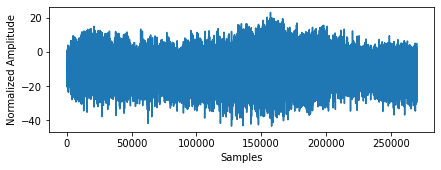

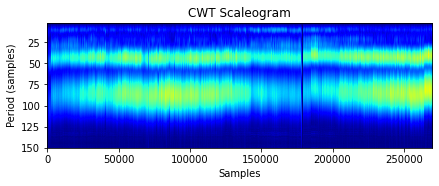

c:\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


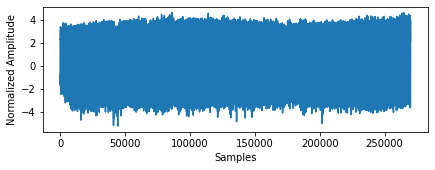

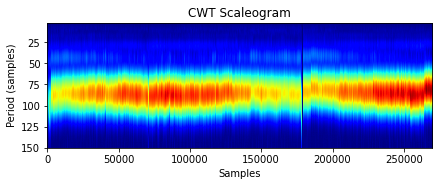

c:\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


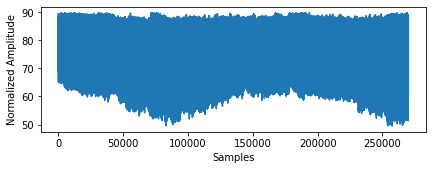

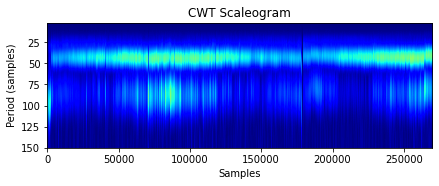

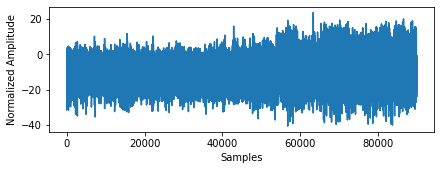

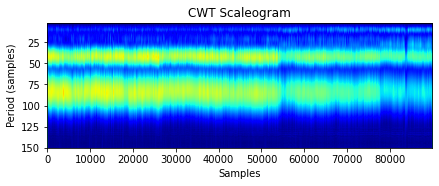

c:\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


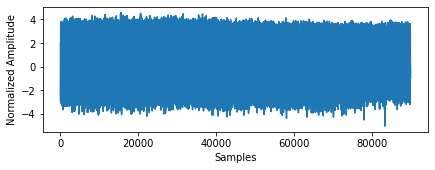

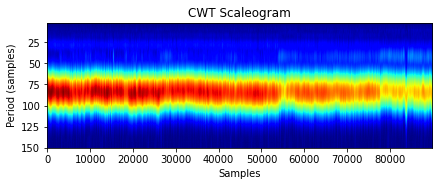

c:\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


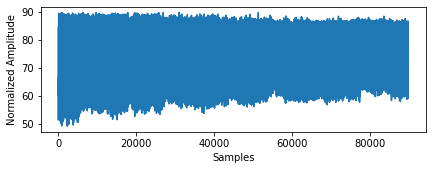

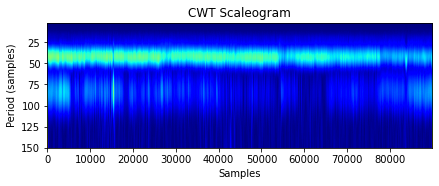

In [24]:
def get_scalogram_coefs(x, features, fs):
    all_coefs = []
    for feat in features:
        scales = np.arange(2, fs*2)
        coefs, freqs = pywt.cwt(x[:,feat], scales, 'cmor-1-1')

        coefs = np.abs(coefs)

        if all_coefs == []:
            all_coefs = coefs[0:100,:]

        else:
            all_coefs = np.vstack((all_coefs,coefs[0:100,:]))


        plt.figure(figsize=(6.9,2.3))
        plt.plot(x[:,feat])
        plt.xlabel('Samples')
        plt.ylabel('Normalized Amplitude')

        plt.figure(figsize=(6.9,2.3))
        plt.imshow(coefs, extent=[0, x.shape[0], 150, 2], cmap='jet', aspect='auto',
                    vmax=coefs.max(), vmin=-coefs.min())
        plt.title('CWT Scaleogram')
        plt.xlabel('Samples')
        plt.ylabel('Period (samples)')
        plt.show()
        
    return all_coefs

X_train = train[:,:9]
Y_train = train[:,9].astype(int)
X_test = test[:,:9]
Y_test = test[:,9].astype(int)
all_coefs_train = get_scalogram_coefs(X_train, [1,3,7], 100)
all_coefs_test = get_scalogram_coefs(X_test, [1,3,7], 100)





In [26]:
coefs_train_scaled = preprocessing.scale(all_coefs_train.T)
#coefs_train_reduced = PCA(n_components=2).fit_transform(coefs_train_scaled)
coefs_test_scaled = preprocessing.scale(all_coefs_test.T)
#coefs_test_reduced = PCA(n_components=2).fit_transform(coefs_test_scaled)
#coefs_embedded = TSNE(n_components=2, perplexity=50, verbose=True).fit_transform(coefs_reduced)

x_train = preprocessing.StandardScaler().fit_transform(coefs_train_scaled)
x_test = preprocessing.StandardScaler().fit_transform(coefs_test_scaled)
clf = LogisticRegressionCV(random_state=0, verbose=1, max_iter=100).fit(x_train, Y_train)




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
c:\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

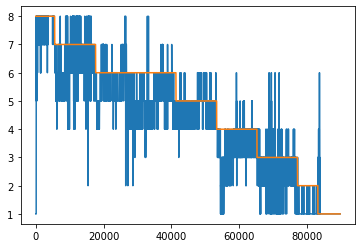

Test RMSE: 0.9610854614871149


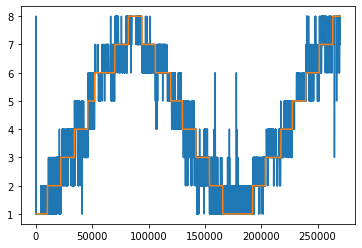

Train RMSE: 0.4160172717212236


In [64]:
conv_width = 1
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

test_pred = moving_average(clf.predict(x_test),conv_width)
plt.figure()
plt.plot(test_pred)
plt.plot(Y_test[conv_width-1:])
plt.show()

print('Test RMSE: {}'.format(np.sqrt(np.mean((test_pred-Y_test[conv_width-1:])**2))))

train_pred = moving_average(clf.predict(x_train),conv_width)
plt.figure()
plt.plot(train_pred)
plt.plot(Y_train[conv_width-1:])
plt.show()

print('Train RMSE: {}'.format(np.sqrt(np.mean((train_pred-Y_train[conv_width-1:])**2))))

## to_plot = [50000,55000]
plt.figure()
plt.plot(clf.predict(x[to_plot[0]: to_plot[1]]))
plt.plot(Y[to_plot[0]: to_plot[1]])
plt.show()

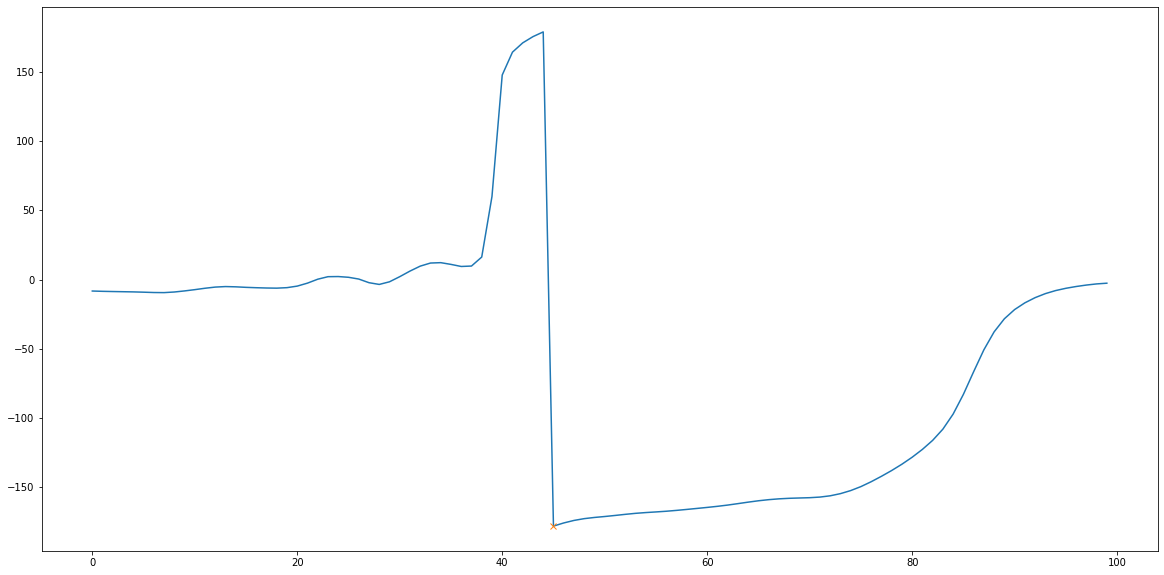

In [169]:
roll = walk1[:100,8]
peaks, _ = find_peaks(-roll, height=100, width=20)

plt.figure(figsize=(20,10))
plt.plot(roll)
plt.plot(peaks, roll[peaks], 'x')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  9.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.0s finished


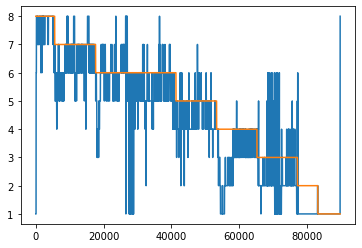

0.41446431749421603


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    6.1s finished


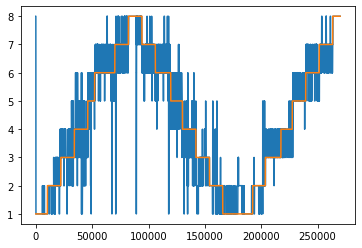

0.8483703703703703


In [63]:
clf_forest = RandomForestClassifier(n_estimators=300, max_depth=5, random_state=0, verbose=True)
clf_forest.fit(x_train, Y_train)

plt.figure()
plt.plot(clf_forest.predict(x_test))
plt.plot(Y_test)
plt.show()

print(clf.score(x_test, Y_test))

plt.figure()
plt.plot(clf_forest.predict(x_train))
plt.plot(Y_train)
plt.show()

print(clf.score(x_train, Y_train))